# Test data iterator with data augmentation

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

import matplotlib.pylab as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../common')

In [4]:
from data_utils import type_1_ids, type_2_ids, type_3_ids, test_ids
from training_utils import get_trainval_id_type_lists, get_test_id_type_list, data_iterator
from training_utils import data_augmentation
from metrics import logloss_mc

Using Theano backend.
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [5]:
train_id_type_list, _ = get_trainval_id_type_lists()

image_size = (224, 224)
batch_size = 5
train_iter = data_iterator(train_id_type_list, 
                           batch_size=batch_size, 
                           image_size=image_size, 
                           data_augmentation_fn=lambda X, Y: data_augmentation(X, Y),
                           verbose=1, 
                           test_mode=False)

Train dataset contains : 
('-', [175, 546, 315], ' images of corresponding types')
Validation dataset contains : 
('-', [75, 234, 135], ' images of corresponding types')


((5, 3, 224, 224), dtype('float32'), (5, 3))


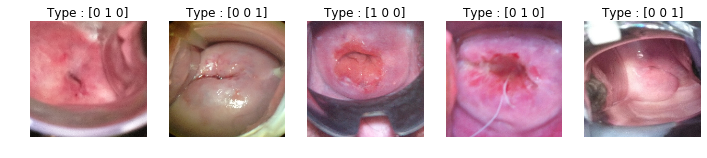

In [53]:
for X, Y in train_iter:
    print(X.shape, X.dtype, Y.shape)
    n = 5
    for counter in range(batch_size):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(X[counter, :, :, :].transpose([1, 2, 0]))
        plt.title("Type : {}".format(Y[counter,:]))
        plt.axis('off')
    
    break

In [54]:
train_id_type_list, _ = get_trainval_id_type_lists()

image_size = (224, 224)
batch_size = 5
train_iter = data_iterator(train_id_type_list, 
                           batch_size=batch_size, 
                           image_size=image_size, 
                           data_augmentation_fn=lambda X, Y: data_augmentation(X, Y),
                           verbose=1, 
                           test_mode=True)

Train dataset contains : 
('-', [175, 546, 315], ' images of corresponding types')
Validation dataset contains : 
('-', [75, 234, 135], ' images of corresponding types')


('Image id/type:', '1011', 'Type_2', '| counter=', 0)
('Image id/type:', '1028', 'Type_3', '| counter=', 1)
('Image id/type:', '1027', 'Type_1', '| counter=', 2)
('Image id/type:', '1012', 'Type_2', '| counter=', 3)
('Image id/type:', '1029', 'Type_3', '| counter=', 4)
((5, 3, 224, 224), dtype('float32'), (5, 3))


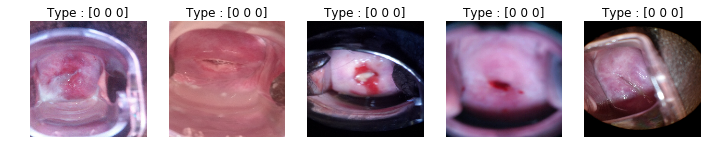

In [60]:
for X, Y, _ in train_iter:
    print(X.shape, X.dtype, Y.shape)
    n = 5
    for counter in range(batch_size):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(X[counter, :, :, :].transpose([1, 2, 0]))
        plt.title("Type : {}".format(Y[counter,:]))
        plt.axis('off')
    
    break

KerasContrib - ImageMaskGenerator

In [5]:
import os
import numpy as np
np.random.seed(2017)

from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from training_utils import get_trainval_id_type_lists2
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)

train_id_type_list, val_id_type_list = get_trainval_id_type_lists2(annotations=annotations, val_split=0.25)

print "Total : %s, Train : %s, Val : %s" % (len(annotations), len(train_id_type_list), len(val_id_type_list))

Total : 208, Train : 156, Val : 52


In [25]:
from preprocessing.image.generators import ImageMaskGenerator

In [14]:
# import preprocessing
# import keras
# help(preprocessing.image.generators.ImageDataGenerator)
# # channel_axis

In [26]:
train_gen = ImageMaskGenerator(featurewise_center=True, featurewise_std_normalization=True,
                               rotation_range=90., 
                               width_shift_range=0.15, height_shift_range=0.15,
                               shear_range=3.14/6.0,
                               zoom_range=0.25,
                               channel_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True)

In [27]:
from image_utils import get_image_data

def xy_provider(image_id_type_list, image_size=(224, 224), verbose=0):    
    for i, (image_id, image_type) in enumerate(image_id_type_list):
        if verbose > 0:
            print("Image id/type:", image_id, image_type, "| counter=", counter)

        img = get_image_data(image_id, image_type)
        if img.dtype.kind is not 'u':
            if verbose > 0:
                print("Image is corrupted. Id/Type:", image_id, image_type)
            continue
        img = cv2.resize(img, dsize=image_size[::-1])
        img = img.transpose([2, 0, 1])
        img = img.astype(np.float32) / 255.0
        
        label = get_image_data(image_id + "_" + image_type, "label")
        label = cv2.resize(label, dsize=image_size[::-1])
        label = label.transpose([2, 0, 1])
        
        yield img, label

In [28]:
train_gen.fit(xy_provider(train_id_type_list), len(train_id_type_list), 
              augment=True, 
              save_to_dir=GENERATED_DATA,
              save_prefix='os_cervix',
              batch_size=4,
              verbose=1)

Load existing file: /home/u2459/Intel_MobileODT/input/generated/os_cervix_stats.npz
No need to recompute statistics


In [30]:
batch_size = 4
print("len(train_id_type_list)=", len(train_id_type_list))
flow = train_gen.flow(xy_provider(train_id_type_list), len(train_id_type_list), batch_size=batch_size)

('len(train_id_type_list)=', 156)


In [36]:
def normalize(in_img, q_min=0.5, q_max=99.5, return_mins_maxs=False):
    """
    Normalize image in [0.0, 1.0]
    mins is array of minima
    maxs is array of differences between maxima and minima
    """
    init_shape = in_img.shape
    if len(init_shape) == 2:
        in_img = np.expand_dims(in_img, axis=2)
    w, h, d = in_img.shape
    img = in_img.copy()
    img = np.reshape(img, [w * h, d]).astype(np.float64)
    mins = np.percentile(img, q_min, axis=0)
    maxs = np.percentile(img, q_max, axis=0) - mins
    maxs[(maxs < 0.0001) & (maxs > -0.0001)] = 0.0001
    img = (img - mins[None, :]) / maxs[None, :]
    img = img.clip(0.0, 1.0)
    img = np.reshape(img, [w, h, d])
    if init_shape != img.shape:
        img = img.reshape(init_shape)
    if return_mins_maxs:
        return img, mins, maxs
    return img

def scale_percentile(matrix, q_min=0.5, q_max=99.5):
    is_gray = False
    if len(matrix.shape) == 2:
        is_gray = True
        matrix = matrix.reshape(matrix.shape + (1,))
    matrix = (255*normalize(matrix, q_min, q_max)).astype(np.uint8)
    if is_gray:
        matrix = matrix.reshape(matrix.shape[:2])
    return matrix  

(4, 3, 224, 224) (4, 2, 224, 224)
-0.187702 1.22178
(4, 3, 224, 224) (4, 2, 224, 224)
-0.169289 0.957732


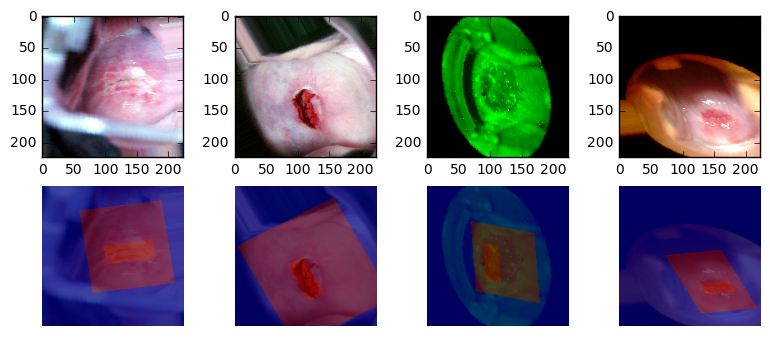

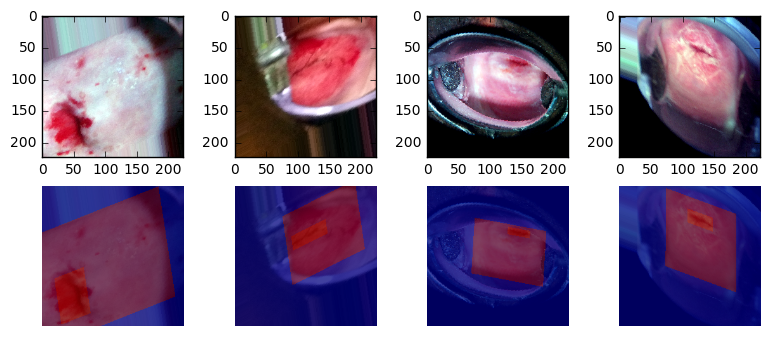

In [37]:
loop_max_counter = 2
for x, y in flow:
    print x.shape, y.shape   
    print x.mean(), x.std()
    n = 5
    for counter in range(batch_size):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(2, n, counter % n + 1)
        plt.imshow(scale_percentile(x[counter, :, :, :].transpose([1, 2, 0])))
        plt.subplot(2, n, n + counter % n + 1)
        plt.imshow(scale_percentile(x[counter, :, :, :].transpose([1, 2, 0])))
        plt.imshow(y[counter, 0, :, :], alpha=0.5)
        plt.imshow(y[counter, 1, :, :], alpha=0.5)    
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

In [ ]:
def get_test_id_type_list2(annotations):
    
    trainval_filepaths = []
    return [(image_id, 'Test') for image_id in test_ids]


In [40]:
trainval_id_type_list = []
for annotation in annotations:
    image_name = annotation['filename']
    image_id = os.path.basename(image_name)[:-4]
    image_type = os.path.split(os.path.dirname(image_name))[1]
    trainval_id_type_list.append((image_id, image_type))

test_id_type_list = [(image_id, 'Test') for image_id in test_ids]
type_ids=(type_1_ids, type_2_ids, type_3_ids)
image_types = ["Type_1", "Type_2", "Type_3"]

for image_ids, image_type in zip(type_ids, image_types):    
    for image_id in image_ids:
        if (image_id, image_type) not in trainval_id_type_list:
            test_id_type_list.append((image_id, image_type))
            

[('277', 'Test'),
 ('68', 'Test'),
 ('115', 'Test'),
 ('450', 'Test'),
 ('356', 'Test'),
 ('406', 'Test'),
 ('199', 'Test'),
 ('88', 'Test'),
 ('251', 'Test'),
 ('123', 'Test'),
 ('223', 'Test'),
 ('92', 'Test'),
 ('335', 'Test'),
 ('224', 'Test'),
 ('261', 'Test'),
 ('415', 'Test'),
 ('369', 'Test'),
 ('47', 'Test'),
 ('511', 'Test'),
 ('151', 'Test'),
 ('408', 'Test'),
 ('484', 'Test'),
 ('288', 'Test'),
 ('496', 'Test'),
 ('121', 'Test'),
 ('49', 'Test'),
 ('338', 'Test'),
 ('382', 'Test'),
 ('39', 'Test'),
 ('375', 'Test'),
 ('183', 'Test'),
 ('502', 'Test'),
 ('376', 'Test'),
 ('330', 'Test'),
 ('116', 'Test'),
 ('424', 'Test'),
 ('347', 'Test'),
 ('349', 'Test'),
 ('208', 'Test'),
 ('170', 'Test'),
 ('143', 'Test'),
 ('463', 'Test'),
 ('259', 'Test'),
 ('100', 'Test'),
 ('119', 'Test'),
 ('162', 'Test'),
 ('7', 'Test'),
 ('500', 'Test'),
 ('214', 'Test'),
 ('319', 'Test'),
 ('14', 'Test'),
 ('293', 'Test'),
 ('129', 'Test'),
 ('398', 'Test'),
 ('187', 'Test'),
 ('176', 'Test'),
 

In [41]:
len(test_id_type_list)

1785